# <h1 style="text-align:center;">Image Caption Generator</h1>


## Libraries 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import sklearn 
import os
import pickle
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input,Dense, LSTM, Embedding,Dropout,add

## Directory

In [2]:
# Directory
BASE_DIR ="D:\\Data_science\\Mini Project\\image caption generater"

# %pwd
WORKING_DIR ='C:\\Users\\mades\\Documents\\Image Caption Generater'

## Create Model

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Extract features from image

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

**Store the features in pickel**

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

**load features from pickle**

In [4]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [5]:
len(features)

8091

**Load captions_doc**

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
len(captions_doc)

3319280

## create mapping of image to captions

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            caption = caption.replace(' +', ' ')

            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
with open('mapping.pickle', 'wb') as f:
    pickle.dump(mapping, f)

In [11]:
with open('mapping.pickle', 'rb') as f:
    mapping = pickle.load(f)

**sample testing to clean(mapping)**

In [12]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
clean(mapping)

In [14]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
with open('all_captions.pickle', 'wb') as f:
    pickle.dump(all_captions, f)

In [17]:
with open('all_captions.pickle', 'rb') as f:
    all_captions = pickle.load(f)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

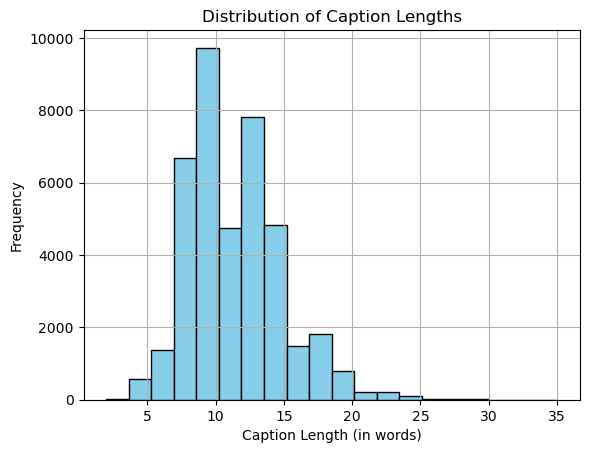

In [20]:
import matplotlib.pyplot as plt

# Assuming caption_lengths is a list containing the lengths of all captions
caption_lengths = [len(caption.split()) for caption in all_captions]

plt.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Caption Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.grid(True)
plt.show()


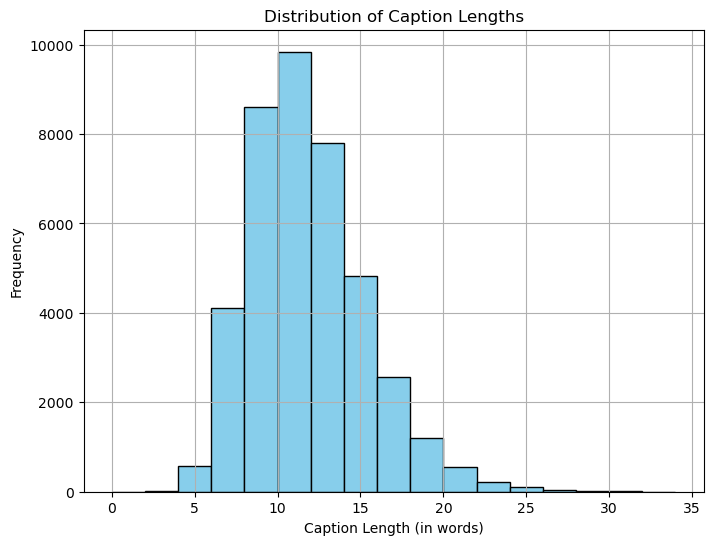

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

# Histogram of Caption Lengths
caption_lengths = [len(caption.split()) for caption in all_captions]

plt.figure(figsize=(8, 6))
plt.hist(caption_lengths, bins=range(0, max(caption_lengths) + 1, 2), color='skyblue', edgecolor='black')
plt.xlabel('Caption Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.grid(True)
plt.show()




## Tokenize the text 

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [23]:
len(tokenizer.word_index)

8484

In [24]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [25]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [26]:
vocab_size

8485

In [27]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## split  data - train, test

In [47]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [48]:
len(image_ids[:split])

7281

In [49]:
len(image_ids)

8091

In [50]:
len(train)


7281

**create data generator to get data in batch (avoids session crash)**

In [51]:
import tensorflow as tf

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def generator():
        while True:
            for key in data_keys:
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        yield (features[key][0], in_seq), out_seq

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=((tf.float32, tf.int32), tf.float32),
        output_shapes=(((4096,), (max_length,)), (vocab_size,))
    ).batch(batch_size)

    return dataset


**encoder model**

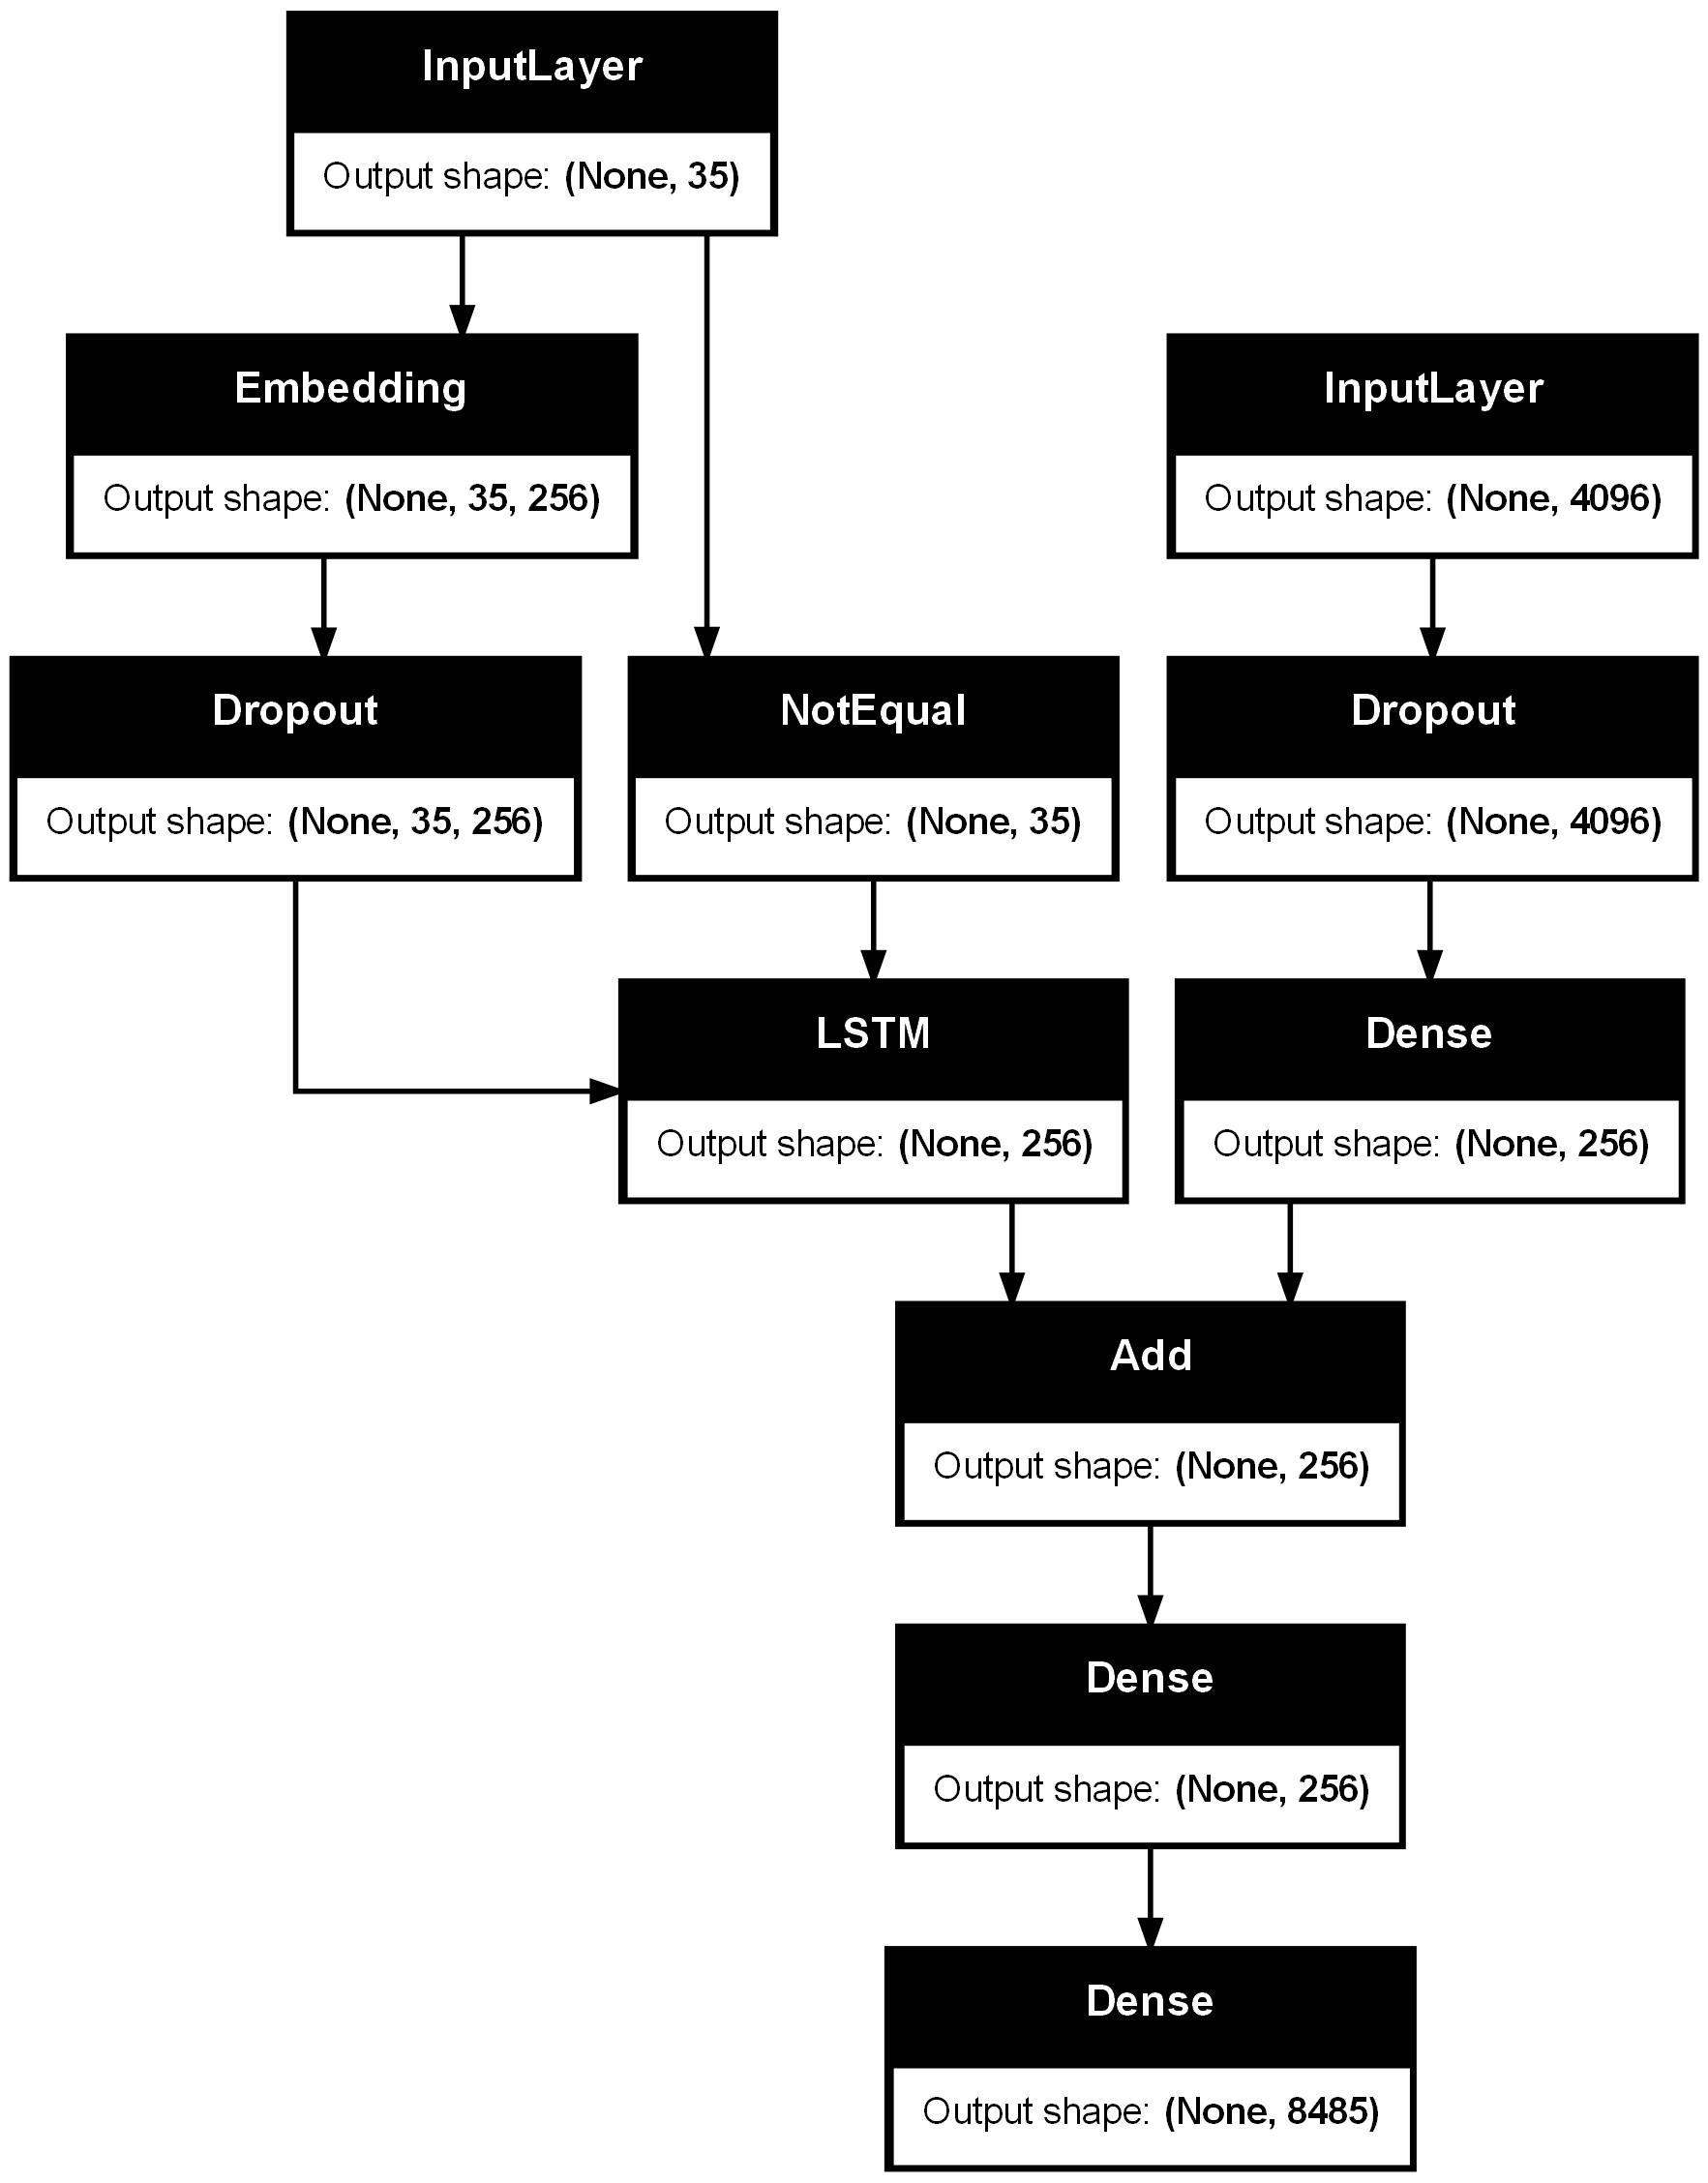

In [52]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

## Train the model

In [70]:
# train the model
epochs = 200
batch_size = 64
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # calculate steps per epoch
    steps_per_epoch = len(train) // batch_size
    # fit for one epoch
    model.fit(generator, epochs=2, steps_per_epoch=steps_per_epoch, verbose=1)


Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.3134
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 8.0726
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 1.5827
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 5.5222
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 1.2560
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 4.7242
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 1.0812
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 4.1960
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.9471
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 3.8527
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.8166
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 3.4604
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.7156
Epoch 2/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 3.1782
Epoch 1/2
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - lo

In [ ]:
 len(train)

**store the trained model**

In [71]:
# Save the model in the native Keras format
model.save(os.path.join(WORKING_DIR, "best200_model.keras"))


In [72]:
from keras.models import load_model
# Load the model
model = load_model(os.path.join(WORKING_DIR, "best200_model.keras"))
# Print model summary
print(model.summary())


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 4096)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 35, 256)           │       2,172,160 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 4096)              │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 35, 256)           │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 35)                │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │       1,048,832 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ dropout_3[0][0],           │
│                               │                           │                 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256)               │               0 │ dense_3[0][0],             │
│                               │                           │                 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │          65,792 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 8485)              │       2,180,645 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 17,978,225 (68.58 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,985,484 (45.72 MB)

None


In [56]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Generate caption for an image

In [57]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

## Calculate BLEU score

In [39]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(1.5, 1, 0, 0)))

  0%|          | 0/1619 [00:00<?, ?it/s]

BLEU-1: 0.415502
BLEU-2: 0.033179


## Caption Generate

In [73]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq collage of one person climbing cliff endseq
startseq group of people are rock climbing on rock climbing wall endseq
startseq group of people climbing rock while one man belays endseq
startseq seven climbers are ascending rock face whilst another man stands holding the rope endseq
startseq several climbers in row are climbing the rock while the man in red watches and holds the line endseq
--------------------Predicted--------------------
startseq collage of one person climbing cliff endseq


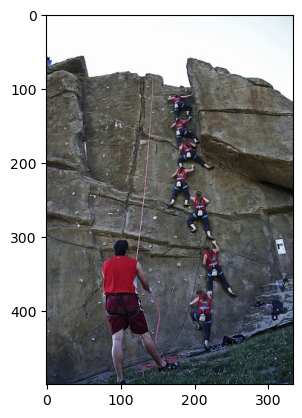

In [74]:
generate_caption("1016887272_03199f49c4.jpg") 

In [75]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

## Predict the new image caption 


Enter path :  "D:\Data_science\Mini Project\image caption generater\Images\123889082_d3751e0350.jpg"


--------------------------------------------------
Predicted Caption: startseq brown dog biting gray dogs ear endseq


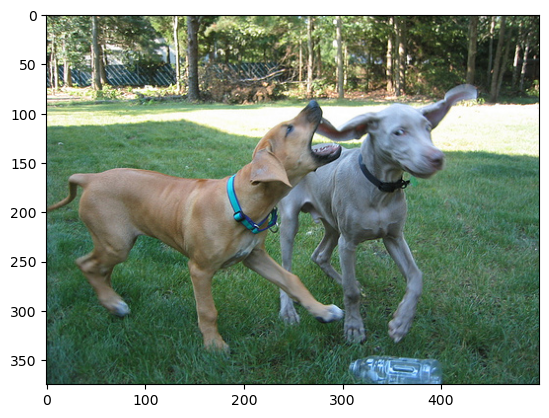

In [89]:
from keras.preprocessing.image import load_img, img_to_array

image_p = input("Enter path : ").strip()  # Strip any leading or trailing whitespace
image_path = image_p.strip('"')  # Remove double quotes from the path
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)


# predict from the trained model
predicted_caption=predict_caption(model, feature, tokenizer, max_length)
print("-" * 50)
# Print the predicted caption
print("Predicted Caption:", '\033[1m' + predicted_caption + '\033[0m')


# Display the image

plt.imshow(load_img(image_path))
plt.axis('on')
plt.show()




In [41]:
# Calculate METEOR score for test data
references = []
predictions = []

for key in tqdm(test):
    captions = mapping[key]
    predicted_caption = predict_caption(model, features[key], tokenizer, max_length)
    references.append(captions)
    predictions.append(predicted_caption)

meteor_score = meteor_score(references, predictions)
print("METEOR Score:", meteor_score)


  0%|          | 0/810 [00:00<?, ?it/s]

METEOR Score: 0.0058479532163742695


In [42]:
import pickle

# Save references and predictions to files
with open('references.pkl', 'wb') as f:
    pickle.dump(references, f)

with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)


In [43]:
# Load references and predictions from files
with open('references.pkl', 'rb') as f:
    references = pickle.load(f)

with open('predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)


In [44]:
from nltk.translate.meteor_score import meteor_score
meteor_score = meteor_score(references, predictions)
print("METEOR Score:", meteor_score)w

METEOR Score: 0.0058479532163742695


Please enter the path to the image.


Enter path :  "C:\Users\mades\Downloads\OIP (1).jpeg"


Loading the image and preprocessing it.
Extracting features from the image using VGG model.
Predicting caption using the trained model.
Predicted Caption:
startseq two dogs are standing alone on some wall endseq
Displaying the image.


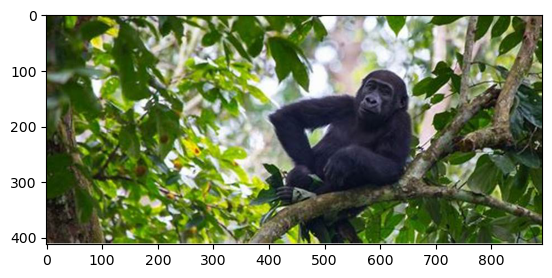

Process completed.


In [51]:
import pyttsx3
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Initialize the text-to-speech engine
engineio = pyttsx3.init()
voices = engineio.getProperty('voices')
engineio.setProperty('rate', 130)  # Adjust speech rate as needed

# Selecting a female voice if available
for voice in voices:
    if "female" in voice.name.lower():
        engineio.setProperty('voice', voice.id)
        break

def speak(text):
    engineio.say(text)
    engineio.runAndWait()
    print(text)

# Speak out the input path prompt
speak("Please enter the path to the image.")
image_p = input("Enter path : ").strip()  # Strip any leading or trailing whitespace
image_path = image_p.strip('"')  # Remove double quotes from the path

# Load the image and preprocess it
speak("Loading the image and preprocessing it.")
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

# Extract features using VGG model
speak("Extracting features from the image using VGG model.")
feature = vgg_model.predict(image, verbose=0)

# Predict caption from the trained model
speak("Predicting caption using the trained model.")
predicted_caption = predict_caption(model, feature, tokenizer, max_length)

# Speak the predicted caption
speak("Predicted Caption:")
speak(predicted_caption)

# Display the image
speak("Displaying the image.")
plt.imshow(load_img(image_path))
plt.axis('on')
plt.show()

# Speak out the completion message
speak("Process completed.")


<h1 style="text-align:center;">Thank you</h1>


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
import fileupload

def upload_image_and_generate_caption():
    # Define the upload function
    def _upload(change):
        # Get the uploaded file
        upload_widget = change['owner']
        img = upload_widget.data[-1]
        
        # Display the uploaded image
        image = Image.open(io.BytesIO(img))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        # Preprocess the image for prediction
        image = image.resize((224, 224))  # Resize image to match model input size
        image = np.array(image) / 255.0  # Normalize pixel values

        # Predict the caption
        y_pred = predict_caption(model, image.reshape((1, 224, 224, 3)), tokenizer, max_length)
        print("Predicted Caption:", y_pred)

    # Create the upload widget
    upload_btn = fileupload.FileUploadWidget(label='Upload')
    upload_btn.observe(_upload, names='data')
    
    # Display the upload widget
    display(upload_btn)

# Example usage
upload_image_and_generate_caption()


In [ ]:
!streamlit run app2.py

